In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterstats

In [2]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd

In [57]:
# file = "../Data/IMAGE_SSPs/SSP1_26/GLANDCOVERDETAIL_30MIN.nc"
file = "../Data/IMAGE_SSPs/SSP1/GLANDCOVER_30MIN.nc" # It seems that SSP1-26 doesn't have the GLANDCOVER set

# file = "Box/Climate Policy Team/02 - Projects/IKEA NDC 1.5° Pathways 20-22/2- Work Packages/WP3 -  LULUCF Pathways/Workflow/Data/IMAGE_SSPs/SSP1_26/GLANDCOVER_30MIN.nc"
# file = "GLANDCOVER_30MIN.nc"
# filedetail = "../Data/IMAGE_SSPs/SSP1_26/GLANDCOVERDETAIL_30MIN.nc"
# filessp2 = "../Data/IMAGE_SSPs/SSP2/GLANDCOVERDETAIL_30MIN.nc"

In [58]:
import xarray as xr
# Useful commands:
# ds = xr.open_dataset(" ")
# ds.plot()
# ds.sel(x = '', ...)

In [59]:
ds = xr.open_dataset(file)

In [61]:
glandcov = ds.GLANDCOVER_30MIN

Variables for GLANDCOVER_30MIN:
Cropland
Pasture
Forest
Other Natural Land
Builtup

In [62]:
glandcov

<xarray.DataArray 'GLANDCOVER_30MIN' (time: 27, latitude: 360, longitude: 720, N: 5)>
[34992000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1970-01-01 1975-01-01 ... 2100-01-01
  * N          (N) |S1 b'1' b'2' b'3' b'4' b'5'
Attributes:
    units:      1
    long_name:  glandcover agregrated to 30 min

N for GLANDCOVERDETAIL
1 Cropland rainfed
2 Cropland irrigated
3 Energy crops rainfed
4 Energy crops irrigated
5 Degraded forest area
6 Protected area

N for GLANDCOVER
1 Cropland
2 Pasture
3 Forest
4 Other Natural Land
5 Builtup

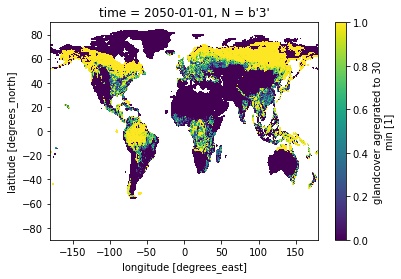

In [63]:
glandcov.sel(N=b'3', time = '2050-01-01').plot()

In [111]:
## Other data
# ds2 = xr.open_dataset(filessp2)
# glandcov2 = ds2.GLANDCOVERDETAIL_30MIN

In [66]:
# Load file with land area per pixel (note values -9999.0 mean 0?)
area_array = np.loadtxt("../Data/IMAGE_SSPs/GAREA_30M.asc", skiprows=6)

In [67]:
area_ds = xr.open_rasterio("../Data/IMAGE_SSPs/GAREA_30M.asc")

In [68]:
# Find some non-zero values
np.where(area_array != -9999.0)

(array([ 12,  12,  12, ..., 291, 291, 291]),
 array([283, 284, 285, ..., 223, 224, 225]))

In [69]:
# extract data for one time point for key variables and multiply by land area
forest = glandcov.sel(N=b'3', time = '2050-01-01') * area_array
pasture = glandcov.sel(N=b'2', time = '2050-01-01') * area_array
cropland = glandcov.sel(N=b'1', time = '2050-01-01') * area_array
other = glandcov.sel(N=b'4', time = '2050-01-01') * area_array


In [ ]:
forest = glandcov.sel(N=b'3', time = '2050-01-01') * area_ds

In [121]:
np.where(forest >1)

(array([ 31,  31,  32, ..., 289, 289, 290]),
 array([584, 585, 571, ..., 218, 230, 226]))

In [144]:
# example data point for forest
forest[289][218]

<xarray.DataArray 'GLANDCOVER_30MIN' ()>
array(1638.2692126)
Coordinates:
    latitude   float64 -54.75
    longitude  float64 -70.75
    time       datetime64[ns] 2050-01-01
    N          |S1 b'3'

In [137]:
# Find the index of a particular longitude and latitude
np.where((forest.longitude == 22.25) & (forest.latitude==0.25))

(array([404]), array([179]))

In [139]:
# Find same point in the area dataset
area_array[179][404]

3077.4

In [143]:
# compare with sum of land types at same point
cropland.sel(longitude = 22.25, latitude = 0.25) + forest.sel(longitude = 22.25, latitude = 0.25) + pasture.sel(longitude = 22.25, latitude = 0.25)+ other.sel(longitude = 22.25, latitude = 0.25)

<xarray.DataArray 'GLANDCOVER_30MIN' ()>
array(3072.07193751)
Coordinates:
    latitude   float64 0.25
    longitude  float64 22.25
    time       datetime64[ns] 2050-01-01

In [8]:
# add borders - open borders file with geopandas
borders = gpd.read_file("../Data/TM_WORLD_BORDERS-0/")

In [25]:
# change borders file to EPSG 4325 projection (not sure if this does anything)
borders = borders.to_crs(epsg=4326)

<AxesSubplot:>

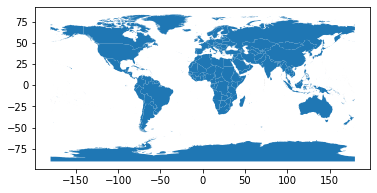

In [60]:
# This would plot the borders and land cov, but doesn't seem to work
borders.plot()
# show(glandcov2.sel(N=b'3', time = '2050-01-01'))


In [ ]:
import rioxarray

In [ ]:
## check coordinates system
glandcov.rio.crs

## change coordinates system
# glandcov2 = glandcov.rio.set_crs("epsg:4326")

In [126]:
# extract borders of specific countries (geopandas uses same lingo as pandas)
ken = borders.loc[borders.ISO3 == 'KEN']
usa = borders.loc[borders.ISO3 == 'USA']
gbr = borders.loc[borders.ISO3 == 'GBR']
nzl = borders.loc[borders.ISO3 == 'NZL']
uga = borders.loc[borders.ISO3 == 'UGA']
uga = borders.loc[borders.ISO3 == 'UGA']
zaf = borders.loc[borders.ISO3 == 'ZAF']
tza = borders.loc[borders.ISO3 == 'TZA']
bra = borders.loc[borders.ISO3 == 'BRA']

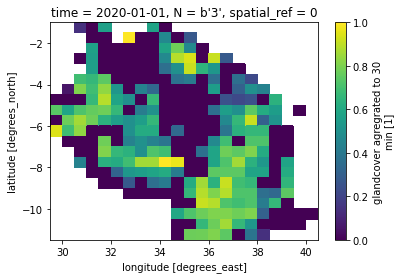

In [140]:
# clip data to specific countries using geopandas and rioxarray
geometries = tza.geometry
clipped = glandcov.rio.clip(geometries, glandcov.rio.crs)
clipped.sel(time = '2020-01-01', N = b'3').plot()


<AxesSubplot:>

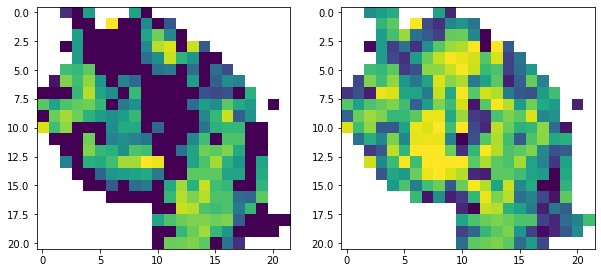

In [149]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
show(clipped.sel(time = '2020-01-01', N = b'3'), ax=ax1)
show(clipped.sel(time = '2070-01-01', N = b'3'), ax=ax2)

In [170]:
def area_map(time, N):
    area = glandcov.sel(N=N, time = time) * area_array
    return area

def country_areas(time, N, country):
    area = area_map(time, N)
    country_borders = borders.loc[borders.ISO3 == country]
    geometries = country_borders.geometry
    clipped = area.rio.clip(geometries, glandcov.rio.crs)

In [174]:
# test = country_areas('2050-01-01', b'3', 'TZA')
area_array.set_crs(glandcov.rio.crs)

AttributeError: 'numpy.ndarray' object has no attribute 'rio'

In [148]:
clipped.sel(time = '2070-01-01', N = b'3').sum()

<xarray.DataArray 'GLANDCOVER_30MIN' ()>
array(178.4171, dtype=float32)
Coordinates:
    time         datetime64[ns] 2070-01-01
    N            |S1 b'3'
    spatial_ref  int64 0

In [11]:
# experimenting with transforming
from rasterio import features
from affine import Affine


lat = np.asarray(borders.LON)
lon = np.asarray(borders.LAT)
trans = Affine.translation(lon[0], lat[0])
scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
transform = trans * scale

In [20]:
out_shape = (len(borders.LON), len(borders.LAT))
shapes = borders.geometry
raster = features.rasterize(shapes, out_shape=out_shape, transform=transform)

In [21]:
# make array from borders file
coords = [borders.LAT, borders.LON]
test = xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

In [105]:
# maybe fiona could be useful?
import fiona
with fiona.open("../Data/TM_WORLD_BORDERS-0/TM_WORLD_BORDERS-0.3.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]